In [1]:
# 引入常用库
import talib  # 技术分析
import pandas as pd
import numpy as np
import scipy.stats as st

import alphalens as al# 因子分析

import pickle
from tqdm import *
import itertools  # 迭代器工具
import datetime as dt
from dateutil.parser import parser

# 画图
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib.pyplot import MultipleLocator
import seaborn as sns

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['serif']
mpl.rcParams['font.family'] = 'serif'
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False

# 图表主题
plt.style.use('ggplot')

# from jqdata import *


# 数据获取

分笔数据来源优矿股票池为000002，399107的成分股在2020-05-06的截面成分股数据

In [2]:
dealAmount = pd.read_csv(
        'data2013_2020.csv', index_col=0, parse_dates=['tradeDate'])

dealAmount = pd.pivot_table(dealAmount,index='tradeDate',columns='secID',values='dealAmount')

D:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
start = min(dealAmount.index) # 起始日期
end = max(dealAmount.index) # 结束日期
codes = dealAmount.columns.tolist() # 股票代码

# 数据获取
daily_price = get_price(codes,start,end,fields=['money','close','pre_close'],panel=False)

# 结构化
money_df = pd.pivot_table(daily_price,index='time',columns='code',values='money')
close_df = pd.pivot_table(daily_price,index='time',columns='code',values='close')
pre_close = pd.pivot_table(daily_price,index='time',columns='code',values='pre_close')

# 数据储存
money_df.to_csv('money_df.csv')
close_df.to_csv('close_df.csv')
pre_close.to_csv('pre_close.csv')

In [4]:
# 数据读取
money_df = pd.read_csv('money_df.csv',index_col=0,parse_dates=[0])
close_df = pd.read_csv('close_df.csv',index_col=0,parse_dates=[0])
pre_close = pd.read_csv('pre_close.csv',index_col=0,parse_dates=[0])

In [5]:
amt_df = money_df / dealAmount # 计算平均单笔成交金额
ret_df = close_df / pre_close - 1 # 当日涨跌幅

# 因子构造

传统动量/反转因子(如常见的Ret20因子)，长期累计收益非常显著，短期却常常出现回撤。为了解决这种情况这里提出一种新的改进方案**"W式切割"**。比如咖啡成分李有苦与甜的对冲,那么在那么过去 20 日的涨跌幅里，为何不能分解出反转与动量的成分？这一问便直接引出了“反转因子的切割问题”。其构建方式如下:

|因子构造|
|--|
|步骤1:对选取股票S,回溯取其20日的数据;|
|步骤2:计算股票S每日的**平均单笔成交金额**(成交金额/成交笔数);|
|步骤3:单笔成交金额高的10个交易日,涨跌幅加总,记作M_high;|
|步骤4:单笔成交金额低的10个交易日,涨跌幅加总,记作M_low;|
|步骤5:理想反转因子M=M_high-M_low;|
|步骤6:对所有股票进行以上操作计算各自的**理想反转因子M**|

In [7]:
def cala_w_factor(df1:pd.DataFrame,df2:pd.DataFrame,win_size:int)->pd.Series:
    '''
    df1,df2:数据需要对齐 以df1为基准对齐
    df1,
    '''
    
    # 数据对齐
    df1,df2 = df1.align(df2,join='right')
    
    # rolling
    iidx = np.arange(len(df1))
    shape = (iidx.size - win_size + 1, win_size)
    strides = (iidx.strides[0], iidx.strides[0])
    res = np.lib.stride_tricks.as_strided(
        iidx, shape=shape, strides=strides, writeable=True)
    
    # 因子计算
    def _cal_m(df1:pd.DataFrame,df2:pd.DataFrame,res:list)->pd.Series:
    
        rank_df = df1.iloc[res].rank()
        cond = (rank_df >= 11)
        m_high = cond * df2.iloc[res]
        m_low = ~cond * df2.iloc[res]

        m_ser = m_high.sum() - m_low.sum()
        m_ser.name = rank_df.index[-1]
        
        return m_ser
    
    return pd.concat([_cal_m(df1,df2,i) for i in res],axis=1).T

In [8]:
M_factor = cala_w_factor(amt_df,ret_df,20)
#M_factor.to_csv('Data/M_factor.csv')

M_factor.head()

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603989.XSHG,603990.XSHG,603991.XSHG,603992.XSHG,603993.XSHG,603995.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2013-01-31,0.239943,-0.181734,0.196284,0.208452,0.006382,0.498687,0.080432,0.264600,0.0,0.058254,...,0.0,0.0,0.0,0.0,0.091353,0.0,0.0,0.0,0.0,0.0
2013-02-01,0.217747,-0.177275,0.206838,0.208169,0.108105,0.566461,0.079361,0.263883,0.0,0.036524,...,0.0,0.0,0.0,0.0,0.132398,0.0,0.0,0.0,0.0,0.0
2013-02-04,0.180769,-0.058559,0.242359,0.201676,-0.025814,0.581337,0.064319,0.283855,0.0,0.039607,...,0.0,0.0,0.0,0.0,0.140118,0.0,0.0,0.0,0.0,0.0
2013-02-05,0.174962,-0.103514,0.199726,0.217641,-0.009729,0.542366,0.147407,0.272058,0.0,0.100535,...,0.0,0.0,0.0,0.0,0.172056,0.0,0.0,0.0,0.0,0.0
2013-02-06,0.161158,-0.046942,0.167811,0.201818,-0.024767,0.578032,0.153769,0.235485,0.0,0.093121,...,0.0,0.0,0.0,0.0,0.146638,0.0,0.0,0.0,0.0,0.0


# 因子分析

讲W反转因子按升序分为5组,调仓周期分别为1,5,10日

In [10]:
#M_factor = pd.read_csv('Data\M_factor.csv',index_col=0,parse_dates=[0])
# price滞后一期避免未来函数
M_factor_data = al.utils.get_clean_factor_and_forward_returns(M_factor.stack(),
                                                              close_df.shift(-1),
                                                              quantiles=5,
                                                              periods=(1, 5, 10))

Dropped 19.5% entries from factor data: 19.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


可以看到因子有较为不错的单调性,第一组有着较强的正向收益。第五组有较强的反向收益,反转能力较好。

<AxesSubplot:title={'center':'Mean Period Wise Return By Factor Quantile'}, ylabel='Mean Return (bps)'>

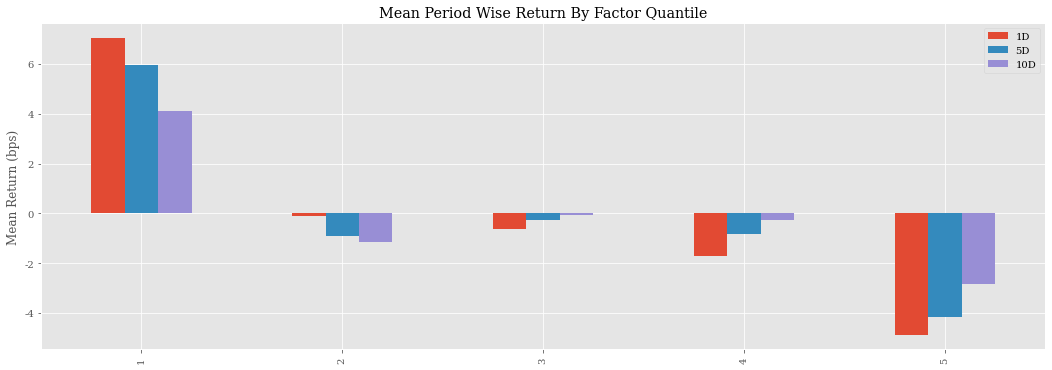

In [12]:
# 查看因子分组收益情况
mean_quant_ret, std_quantile = al.performance.mean_return_by_quantile(
    M_factor_data)

mean_quant_rateret = mean_quant_ret.apply(
    al.utils.rate_of_return, axis=0,base_period = '1D'
)
al.plotting.plot_quantile_returns_bar(mean_quant_rateret)

In [13]:
# 查看IC
ic = al.performance.factor_information_coefficient(M_factor_data)
al.plotting.plot_information_table(ic)

Information Analysis


,1D,5D,10D
IC Mean,-0.006,-0.014,-0.016
IC Std.,0.133,0.133,0.138
Risk-Adjusted IC,-0.045,-0.107,-0.118
t-stat(IC),-1.858,-4.432,-4.891
p-value(IC),0.063,0.000,0.000
IC Skew,0.647,1.140,1.243
IC Kurtosis,1.744,2.438,2.360


In [19]:
# 查看RANK IC
periods = al.utils.get_forward_returns_columns(M_factor_data.columns)
# jq [i for i in periods if i not in ['factor', 'factor_quantile']]
periods = list(map(lambda p: pd.Timedelta(p).days, periods))

autocorrelation = pd.concat(
    [
        al.performance.factor_rank_autocorrelation(M_factor_data, period)
        for period in periods
    ],
    axis=1,
)

auto_corr = pd.DataFrame()
for period, p_data in autocorrelation.iteritems():
    auto_corr.loc["Mean Factor Rank Autocorrelation",
                  "{}D".format(period)] = p_data.mean()
al.utils.print_table(auto_corr.apply(lambda x: x.round(3)))

,1D,5D,10D
Mean Factor Rank Autocorrelation,0.916,0.647,0.398


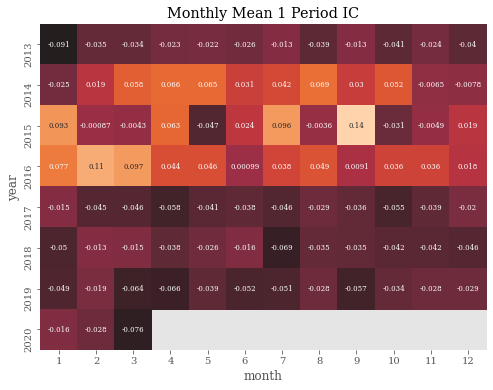

In [25]:
mean_monthly_ic = al.performance.mean_information_coefficient(
            M_factor_data,
            by_time="M",
        )

mean_monthly_ic.index = pd.MultiIndex.from_tuples(
        [[i.year, i.month] for i in mean_monthly_ic.index],
        names=["year", "month"])

plt.figure(figsize=(8,6))
plt.title("Monthly Mean 1 Period IC")

# 1 periods IC headmap
sns.heatmap(mean_monthly_ic['1D'].unstack(),
            annot=True,
           annot_kws={"size": 7},
           linecolor='white',
           center=-0.1,
           cbar=False);

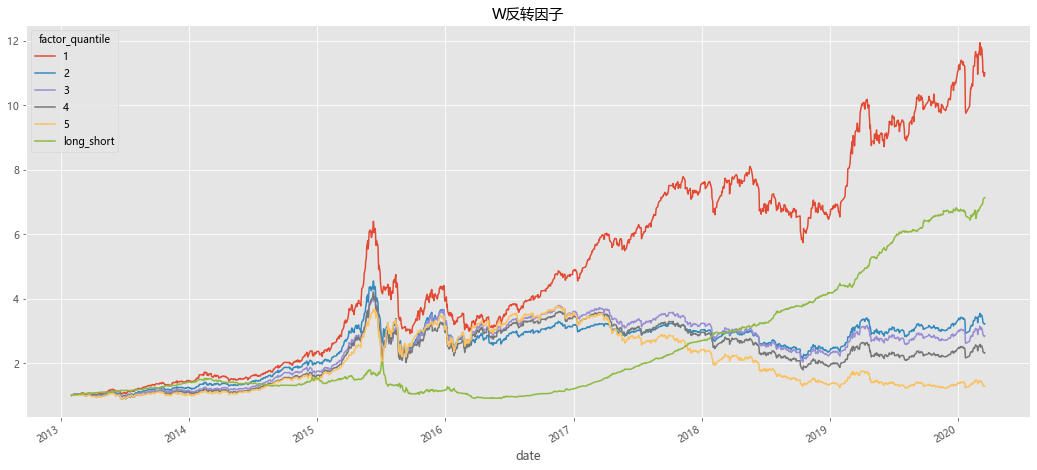

In [31]:
factor_data = M_factor_data[['1D', 'factor_quantile']].copy()

pivot_ret = pd.pivot_table(factor_data.reset_index(
), index='date', columns='factor_quantile', values='1D')

# 多空收益
ls_ret = pivot_ret[1] - pivot_ret[5]

# 计算累计收益
mpl.rcParams['font.family'] = 'Microsoft YaHei'
algriothm_cum = np.exp(np.log1p(pivot_ret).cumsum())
algriothm_cum['long_short'] = np.exp(np.log1p(ls_ret).cumsum())
algriothm_cum.plot(figsize=(18, 8), title='W反转因子');

# 反转之力的微观来源

为了更好地展开讨论，我们首先引入一张逐笔成交金额的金字塔图。我们通过对 2013-2020年间全部A股逐笔成交明细数据的统计，画出了A股逐笔成交金额的整体分布，其中横向红色柱子的长度代表该金额水平上的成交笔数。 从形状上看，这是一个畸形的金字塔，底部极宽，顶部极窄。其表征的义是，大多数被撮合成功的成交，其成交金额都是很小的，中位数在13616.03元，18969.78元是 80% 分位，22948.54元已经是 90%分位，10万元以上的成交几乎是凤毛麟角。最显眼的红点是金字塔的重心（即平均值），意义是全部A股在此6年间的平均每笔成交金额为14869.51元。

成交额均值:14869.5179
中位数:13616.0327
80%分位:18969.7874
90%分位:22948.5487



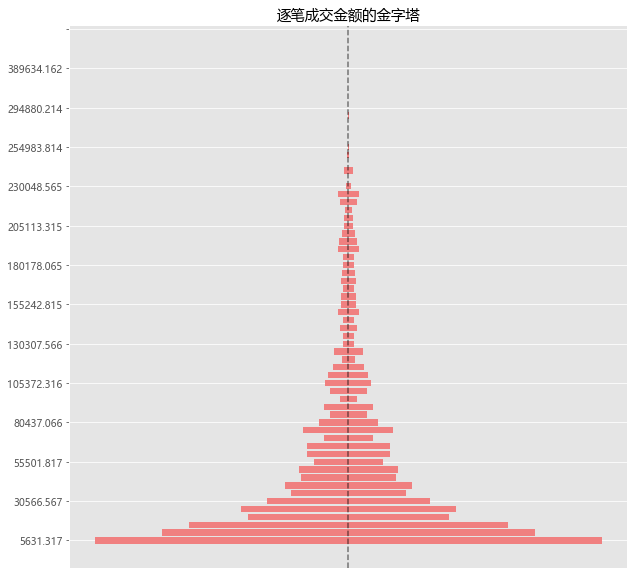

In [9]:
df = pd.concat([amt_df.stack(), dealAmount.stack()], axis=1)
df.columns = ['amt', 'dealamount']

# 丢弃缺失值
df_ = df.dropna().copy()

# 统计平均成交
df_['rng'] = pd.cut(df_['amt'], 150)
stat_df = df_.reset_index(drop=True)

# 按金额统计笔数分布
stat_ser = stat_df.groupby('rng')['dealamount'].apply(
    lambda x: np.ptp(x) if len(x) > 0 else np.nan)
stat_ser = stat_ser.dropna().copy()

# 统计平均成交
describe_ser = df_['amt'].describe(percentiles=[0.8, 0.9])

mean = describe_ser['mean']
median = describe_ser['50%']
percent_80 = describe_ser['80%']
percent_90 = describe_ser['90%']

print('成交额均值:%.4f\n中位数:%.4f\n80%%分位:%.4f\n90%%分位:%.4f\n' %
      (mean, median, percent_80, percent_90))

# 画图所需
idx_y = range(len(stat_ser))
v = stat_ser.values

cat = np.array(stat_ser.index.values)
right_label = [i.right for i in cat]

mpl.rcParams['font.family'] = 'Microsoft YaHei'
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title('逐笔成交金额的金字塔')

plt.barh(y=idx_y,
         width=- v / 2,
         tick_label=right_label,
         color='#F08080')

plt.barh(y=idx_y,
         width=v / 2,
         tick_label=right_label,
         color='#F08080')

plt.axvline(0, ls='--', color='black', alpha=0.5)
plt.xticks([])
y_major_locator = MultipleLocator(5)  # 每隔5个值显示一个标签
ax = plt.gca()
ax.yaxis.set_major_locator(y_major_locator)

逐笔成交金额的金字塔，不是本文讨论的重点，但它却为我们提供了一个理解 W式切割的绝佳视角。不妨设想，对于每一个股票、每一个交易日，我们都分别画 一个类似的金字塔（形态会略显毛糙），W式切割等于是说：让我们回看过去 20 个 交易日，然后比较每日金字塔的重心（平均值）高低，取重心高的 10 日的涨跌幅加总得到M_high，重心低的 10 日则得到M_low。在这个图象之下，如果我们进一步追问，重心代表了交易行为的什么特征呢？答案是相当模糊的，原因就在于，平均值是一个很弱的统计量，重心（平均单笔成交金额）提高，有可能是因为大单成交增加了，有可能是因为小单成交减少了，也有可能是大单被更大的大单替代了。换 言之，从均值出发，很难反推关于逐笔成交金额原始分布的细节信息。顺着这一思路，为使W式切割能够得到更多的微观信息，我们考虑用分位数代替平均值，作为新的切割标准，如下表：

|因子构造|
|--|
|步骤1:对选取股票S,回溯取其20日的数据;|
|步骤2:计算股票S每日的**平均单笔成交金额**(成交金额/成交笔数)分布的**1/16分位值**;|
|步骤3:单笔成交金额高的10个交易日,涨跌幅加总,记作M_high;|
|步骤4:单笔成交金额低的10个交易日,涨跌幅加总,记作M_low;|
|步骤5:理想反转因子M=M_high-M_low;|
|步骤6:对所有股票进行以上操作计算各自的**理想反转因子M**|

In [15]:
def cala_hl_factor(df1: pd.DataFrame, df2: pd.DataFrame, win_size: int, q: float) -> pd.Series:
    '''
    df1,df2:数据需要对齐 以df1为基准对齐
    df1:amt
    df2:pct_chg
    '''

    # 数据对齐
    df1, df2 = df1.align(df2, join='right')
    
    idx = df1.index[win_size - 1:]
    # rolling
    iidx = np.arange(len(df1))
    shape = (iidx.size - win_size + 1, win_size)
    strides = (iidx.strides[0], iidx.strides[0])
    res = np.lib.stride_tricks.as_strided(
        iidx, shape=shape, strides=strides, writeable=True)

    # 获取条件
    def _get_cond(df1: pd.DataFrame, res: list) -> pd.Series:
        
        slice_df = df1.iloc[res]
        rank_df = slice_df.quantile(q)
        tmp_name = slice_df.index[-1]
        cond = (slice_df >= rank_df)
    
        return cond
    
    
    # 获取cond，和拆分后的列
    x_list = [[_get_cond(df1,i),df2.iloc[i]] for i in res]
    
    m_high = pd.concat([np.sum(i[0]*i[1]) for i in x_list],axis=1).T
    m_high.index = idx
    m_low = pd.concat([np.sum(~i[0]*i[1]) for i in x_list],axis=1).T
    m_low.index = idx
        
    return m_high,m_low

def grid_w_factor(amt_df: pd.DataFrame, ret_df: pd.DataFrame) -> dict:
    '''
    获取1/16至15/16分位数的m_high，m_low
    '''

    df_dict = {}

    step = np.arange(1, 16)/16
    label = [f'{i}/16' for i in range(1, 16)]

    for n, i in tqdm(zip(label, step), desc='计算中', total=len(step)):

        df_dict[n + '_h'],df_dict[n + '_l'] = cala_hl_factor(amt_df, ret_df, 20, i)

    return df_dict

In [17]:
# 各分位数切割W因子
factor_dict = grid_w_factor(amt_df,ret_df)

计算中: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [1:07:36<00:00, 270.42s/it]


In [19]:
# 数据储存
# with open('m_dict1.pkl','wb') as pkl_file:
#     pickle.dump(factor_dict,pkl_file)

In [6]:
# 数据读取
with open('m_dict1.pkl','rb') as pkl_file:
    factor_data = pickle.load(pkl_file)

In [63]:
def grid_cala_ic(factor_df: dict, close_df: pd.DataFrame, method: str = 'normal') -> pd.DataFrame:

    ic_dic = {}
    for k, v in factor_df.items():

        x_factor = al.utils.get_clean_factor_and_forward_returns(v.stack(),
                                                                 close_df.shift(
            -1),
            quantiles=1,
            periods=(1,))

        ic_dic[k] = cala_rank_ic(x_factor, method)

    return ic_dic


def cala_rank_ic(factor_df: pd.DataFrame, method: str) -> float:

    if method == 'rank':

        return st.spearmanr(factor_df['1D'], factor_df['factor'])[0]

    else:

        return st.pearsonr(factor_df['1D'], factor_df['factor'])[0]

In [66]:
# 获取各分位数W因子IC值
ic_dict = grid_cala_ic(factor_data,close_df)

Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropp

我们的计算结果显示，当采用1/16分位值作为切割标准时，M_high的IC为0.0012， M_low 的IC为0.034，M_high成分都呈现了反转特性。考虑到“切割”的原始动机是将动量与反转两个成分尽可能地拆分开，显然，这不是一个很理想的切割结果。

接下来依此类推，我们可以改用其他分位值作为切割标准，分别测试2/16分位、3/16分位、4/16分位…15/16分位的情形。这里得出了非常有趣的结论：随着分位值的提高，M_high 的反转特性越来越强（蓝点，IC是负的，但绝对值越来越大）,M_low的反转特性逐渐提高（红点，IC 从正值慢慢向零靠拢）。总体效果像一个向右敞开的喇叭口，随着越往横轴右边（高分位），M_high 与 M_low之间的 IC 差距越大。也就是说，切割标准选用越高的分位值，W式切割的效果越好。这意味着，决定反转强度的因素，主要来源于成交金额分布的高分位区，也即大单成交区。

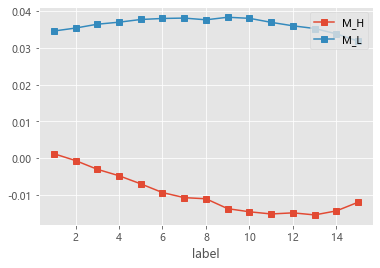

In [68]:
ic_df = pd.Series(ic_dict)
ic_df = ic_df.to_frame('ic')

# 整理数据格式
ic_df['attr'] = list(map(lambda x: 'M_'+x[-1].upper(), ic_df.index))
ic_df['label'] = list(map(lambda x: int(x.split('/')[0]), ic_df.index))

ic_df = pd.pivot_table(ic_df,
                       index='label',
                       columns='attr',
                       values='ic')

ic_df.plot(marker='s')
plt.legend(loc='upper right')

In [14]:
def grid_factor(factor_data:dict)->dict:
    
    k = [f'{i}/16' for i in range(1,16)]
    
    w_dict = {}
    
    for i in k:
        
        w_dict[i] = factor_data[i+'_h'] - factor_data[i+'_l']
        
    return w_dict

def cal_w_icir(w_factor:dict,close_df:pd.DataFrame)->pd.DataFrame:
    
    df = pd.DataFrame(index=list(w_factor.keys()),columns=['IC','IR'])
    
    for k,v in w_factor.items():
        
        x_factor_data = al.utils.get_clean_factor_and_forward_returns(v.stack(),
                                                                      close_df.shift(-1),
                                                                      quantiles=1,
                                                                      periods=(1,))

        rank_ic_ser = al.performance.factor_information_coefficient(x_factor_data)
        ic_mean = rank_ic_ser['1D'].mean()
        ir = ic_mean / rank_ic_ser['1D'].std()
        
        df.loc[k,'IC'] = ic_mean
        df.loc[k,'IR'] = ir
        
    return df

In [44]:
w_factor = grid_factor(factor_data)

icir = cal_w_icir(w_factor,close_df)

Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Dropped 18.9% entries from factor data: 18.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:label='b1f1bb99-391a-4df4-9f29-9c3b6884b1df'>

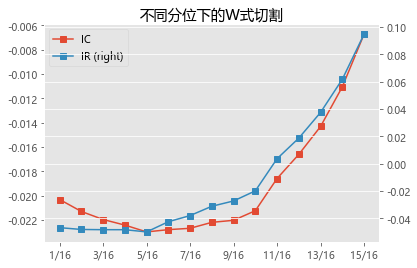

In [59]:
chart = icir.plot.line(y='IC',marker='s',title='不同分位下的W式切割')
icir.plot.line(y='IR',secondary_y=True,marker='s',ax=chart)